# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

# Model Selection

To improve our metrics, we chose two different approaches:  
1. Random Forest
2. Neural Network

Random forest classification is used in two different ways here. First, we use it to reduce the number of variables and select the most important ones to use in further analyses. Second, it is an excellent tool for classification tasks and was also already used for the SOF dataset.

We additionally implemented neural networks to try out a TensorFlow based method for our classification problem, since it was the content of the course.

We also added a logistic regression model based o the most important variables to see, if there is any improvement.

## Prepare data

In [2]:
# mount google drive if needed
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data
v1df_wide = pd.read_csv('/content/drive/MyDrive/OPENCAMP_OSTEO_PROJECT/v1df_wide.csv', sep ='\t')

In [4]:
# Columns to convert to categorical
columns_to_convert = ['V1DOCF', 'V1VERT', 'V1FALL', 'V1HIP50', 'V1SMOKE',
                      'V1ESTRK', 'V1EPARK', 'V1EARTH', 'V1HYTEN', 'V1EDIAB',
                      'V1THYUSE', 'V1OESUSE', 'V1ANTDEP', 'V1THIUSE', 'V1AC2040',
                      'V1DIZZY', 'V1PSTHY2', 'V1PFX', 'V1HIPI']

# Convert selected columns to categorical
v1df_wide[columns_to_convert] = v1df_wide[columns_to_convert].astype('category')

# One-hot encode categorical variables with more than 2 categories
# columns_to_encode = ['V1SMOKE', 'V1THIUSE', 'V1OESUSE', 'V1THIUSE']
# v1df_wide_enc = pd.get_dummies(v1df_wide, columns=columns_to_encode, drop_first=True)

# Combine categories, 0 = never + 1 & 2 = ever
columns_to_encode = ['V1SMOKE', 'V1THIUSE', 'V1OESUSE']
  # Define function to perform the transformation
def combine_levels(columns_to_encode):
    return columns_to_encode.replace({2: 1})

# Apply the function to each categorical variable
for columns_to_encode in v1df_wide.columns:
    v1df_wide[columns_to_encode] = combine_levels(v1df_wide[columns_to_encode])

In [5]:
#delete unnamed column
v1df_wide.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
# split dataset
X = v1df_wide.loc[:, v1df_wide.columns != "V1HIPI"]
y = v1df_wide["V1HIPI"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [9]:
#Undersampling majority class
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split

# Initialize NearMiss
nm = NearMiss()

# Undersample the majority class
X_train_undersampled, y_train_undersampled = nm.fit_resample(X_train, y_train)

In [10]:
# remove height and weight due to BMI variable
drop = ['V1WGHT', 'V1HGHT']
X_train_undersampled = X_train_undersampled.drop(drop, axis =1)
X_train = X_train.drop(drop, axis =1)
X_test = X_test.drop(drop, axis =1)

## Feature Engineering

     Feature  Importance
18   V1CHRTM    0.140339
7   V1AVDRWK    0.140311
0      V1BMI    0.119618
20  V1WLKSPD    0.092690
22  V1CSNORM    0.092397
2      V1AGE    0.091276
1   V1SHT3MS    0.069376
19  V1STPLGT    0.055929
25     V1PFX    0.023830
3     V1DOCF    0.017577


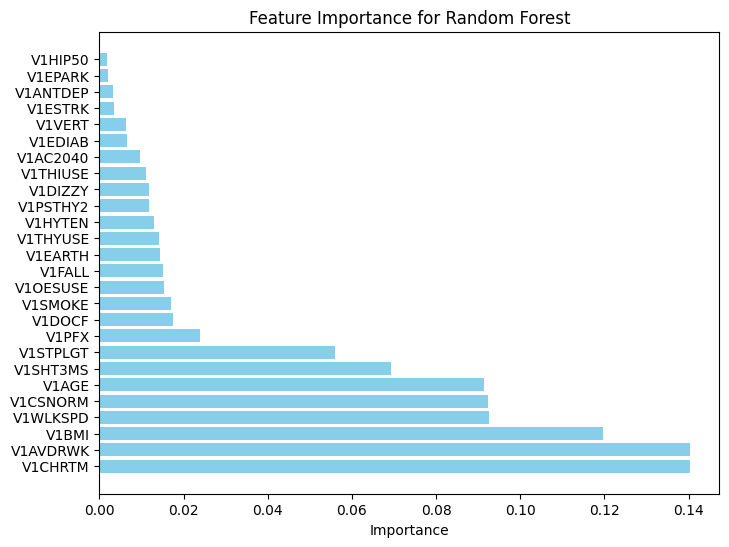

In [11]:
# feature reduction
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_classifier_und = RandomForestClassifier(n_estimators=100, random_state=42)

# Re-Train the classifier
rf_classifier_und.fit(X_train_undersampled, y_train_undersampled)

# Get feature importances
feature_importances = rf_classifier_und.feature_importances_

# Add feature im,[rtamc]
feature_importance_df = pd.DataFrame({'Feature': X_train_undersampled.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# choose top 10 variables
top_10 = feature_importance_df[:10]
print(top_10)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Random Forest')
plt.show()

In [12]:
# selecting top 10 variables

X_train_undersampled_top = X_train_undersampled[top_10['Feature']]
X_test_top = X_test[top_10['Feature']]

# Implementation

## Model 1: Logistic regression with top 10 variables

In [13]:
# Logistic regression with top 10 variables
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg_und = LogisticRegression(random_state=16, max_iter = 5000)

# fit the model with undersampled data
logreg_und.fit(X_train_undersampled_top, y_train_undersampled)

LogisticRegression(max_iter=5000, random_state=16)

## Model 2: Random forest with top 10 variables

In [14]:
# Random forest with top 10 variables
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the classifier
rf_classifier.fit(X_train_undersampled_top, y_train_undersampled)

RandomForestClassifier(random_state=42)

## Model 3: Neural network with top 10 variables

In [17]:
# Neural Network with top 10 variables
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Build a simple neural network for logistic regression
model = Sequential()
model.add(Dense(units=64, input_dim=10, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_undersampled_top, y_train_undersampled, epochs=40, batch_size=1, verbose=1)

Epoch 1/40
2264/2264 [==============================] - 6s 2ms/step - loss: 0.7659 - accuracy: 0.6343
Epoch 2/40
2264/2264 [==============================] - 4s 2ms/step - loss: 0.6117 - accuracy: 0.6877
Epoch 3/40
2264/2264 [==============================] - 5s 2ms/step - loss: 0.5734 - accuracy: 0.6930
Epoch 4/40
2264/2264 [==============================] - 4s 2ms/step - loss: 0.5585 - accuracy: 0.7063
Epoch 5/40
2264/2264 [==============================] - 3s 2ms/step - loss: 0.5431 - accuracy: 0.7116
Epoch 6/40
2264/2264 [==============================] - 4s 2ms/step - loss: 0.5319 - accuracy: 0.7301
Epoch 7/40
2264/2264 [==============================] - 5s 2ms/step - loss: 0.5286 - accuracy: 0.7284
Epoch 8/40
2264/2264 [==============================] - 4s 2ms/step - loss: 0.5197 - accuracy: 0.7332
Epoch 9/40
2264/2264 [==============================] - 4s 2ms/step - loss: 0.5142 - accuracy: 0.7390
Epoch 10/40
2264/2264 [==============================] - 4s 2ms/step - loss: 0.515

# Evaluation Metrics

To evaluate our models, we use three metrics:

1. Accuracy
2. Sensitivity
3. Specificity

## Model 1: Logistic regression with top 10 variables

In [18]:
y_pred_und = logreg_und.predict(X_test_top)
# Evaluate accuracy
model1_accuracy = accuracy_score(y_test, y_pred_und)
print(f"Model 1 Accuracy: {model1_accuracy}")

Model 1 Accuracy: 0.4767321613236815


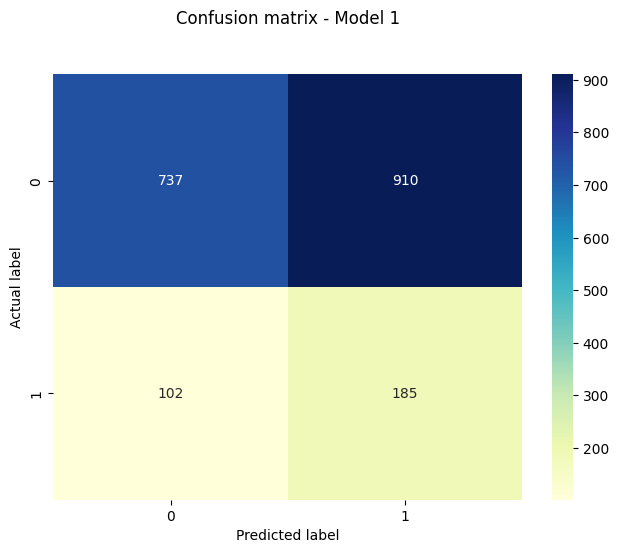

In [19]:
# confusion matrix - model 1
# import the metrics class
from sklearn import metrics
cnf_matrix_model1 = metrics.confusion_matrix(y_test, y_pred_und)
# create heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(pd.DataFrame(cnf_matrix_model1), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix - Model 1', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
specificity1 = cnf_matrix_model1[0,0]/(cnf_matrix_model1[0,0]+cnf_matrix_model1[0,1])
print('Model 1 Specificity : ', specificity1 )

sensitivity1 = cnf_matrix_model1[1,1]/(cnf_matrix_model1[1,0]+cnf_matrix_model1[1,1])
print('Model 1 Sensitivity : ', sensitivity1)

Model 1 Specificity :  0.4474802671523983
Model 1 Sensitivity :  0.6445993031358885


## Model 2: Random forest with top 10 variables

In [21]:
# Make predictions on the test set
rf_pred = rf_classifier.predict(X_test_top)
# Evaluate accuracy
RF_accuracy = accuracy_score(y_test, rf_pred)
print(f"Model 2 Accuracy: {RF_accuracy}")

Model 2 Accuracy: 0.4027921406411582


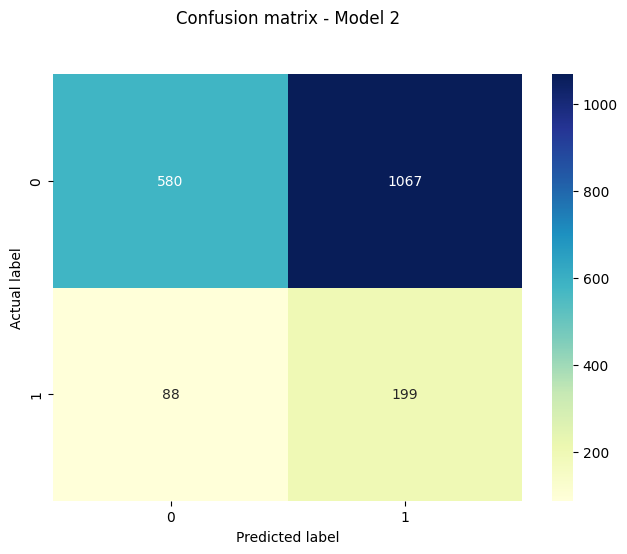

In [22]:
# confusion matrix - model 2
cnf_matrix_model2 = metrics.confusion_matrix(y_test, rf_pred)
# create heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(pd.DataFrame(cnf_matrix_model2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix - Model 2', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [23]:
specificity2 = cnf_matrix_model2[0,0]/(cnf_matrix_model2[0,0]+cnf_matrix_model2[0,1])
print('Model 2 Specificity : ', specificity2 )

sensitivity2 = cnf_matrix_model2[1,1]/(cnf_matrix_model2[1,0]+cnf_matrix_model2[1,1])
print('Model 2 Sensitivity : ', sensitivity2)

Model 2 Specificity :  0.3521554341226472
Model 2 Sensitivity :  0.6933797909407665


## Model 3: Neural network with top 10 variables

In [24]:
# Make predictions on the test set
y_pred_prob_NN = model.predict(X_test_top)
y_pred_NN = (y_pred_prob_NN > 0.5).astype(int)

# Evaluate accuracy
NN_accuracy = accuracy_score(y_test, y_pred_NN)
print(f"Model 3 Accuracy: {NN_accuracy}")

61/61 [==============================] - 0s 1ms/step
Model 3 Accuracy: 0.3893485005170631


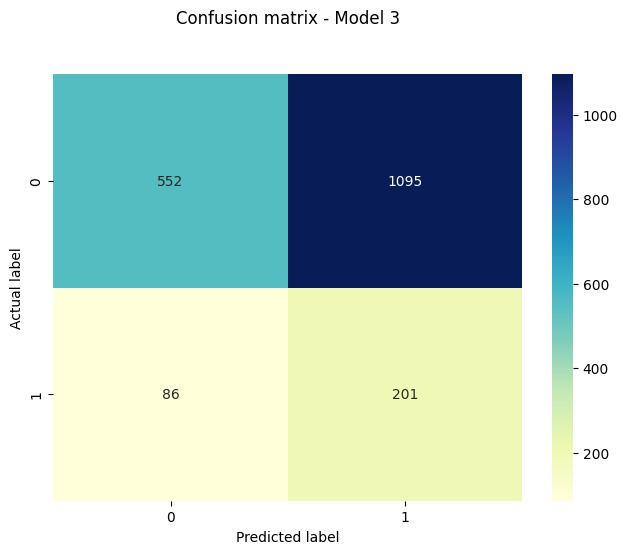

In [25]:
# confusion matrix - model 3
cnf_matrix_model3 = metrics.confusion_matrix(y_test, y_pred_NN)
# create heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(pd.DataFrame(cnf_matrix_model3), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix - Model 3', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [26]:
specificity3 = cnf_matrix_model3[0,0]/(cnf_matrix_model3[0,0]+cnf_matrix_model3[0,1])
print('Model 3 Specificity : ', specificity3)

sensitivity3 = cnf_matrix_model3[1,1]/(cnf_matrix_model3[1,0]+cnf_matrix_model3[1,1])
print('Model 3 Sensitivity : ', sensitivity3)

Model 3 Specificity :  0.33515482695810567
Model 3 Sensitivity :  0.7003484320557491


# Comparative Analysis

Evaluation metrics table

| Model | Model Specification | Accuracy | Specificity | Sensitivity |
| :- | :- | :-: | :-: | :-: |
| Baseline Model 1 | Logistic Regression, unsampled | 0.85 | 1.00 | 0.00 |
| Baseline Model 2 | Logistic Regression, undersampled | 0.46 | 0.43 | 0.63 |
| Model 1 | Logistic Regression, undersampled, top 10 | 0.48 | 0.45 | 0.64 |
| Model 2 | Random Forest, undersampled, top 10 | 0.40 | 0.35 | 0.69 |
| Model 3 | Neural Network, undersampled, top 10 | 0.39 | 0.34 | 0.70 |

As can be seen, the different models and variable selection technique do not help to improve the metrics. All metrics are bad and not sufficient for any reliable classification.